In [10]:
# ============================================================================
# Aureus Sigma Capital - Phase 15b: Dynamic QVM Composite Backtest
# Notebook: 15b_dynamic_composite_backtest.ipynb
#
# Objective:
#   To engineer and backtest a DYNAMIC composite alpha signal that adapts its
#   factor weights based on the prevailing market regime, leveraging the key
#   insights from the archived "Test C" experiment.
#
# Methodology:
#   1. Load validated data artifacts from Phase 14 and market regimes.
#   2. Engineer a dynamic composite score:
#      - In "Calm" regimes: A traditional QVM blend.
#      - In "Stress" regimes: A defensive QV-Reversal blend.
#   3. Backtest the resulting long-only (Quintile 5) portfolio.
#   4. Compare performance against the static QVR composite and the VN-Index.
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import yaml
from pathlib import Path
from sqlalchemy import create_engine, text
import sys
import pickle

# --- Environment Setup ---
warnings.filterwarnings('ignore')
sys.path.append('../../../production') # Add production modules to path
from universe.constructors import get_liquid_universe_dataframe

# --- Standardized Institutional Visualization Palette ---
PALETTE = {
    'primary': '#16A085', 'secondary': '#34495E', 'positive': '#27AE60',
    'negative': '#C0392B', 'highlight_1': '#2980B9', 'highlight_2': '#E67E22',
    'neutral': '#7F8C8D', 'grid': '#BDC3C7', 'text': '#2C3E50'
}
STRATEGY_COLORS = {
    'QVM_Composite': PALETTE['primary'], 'Value': PALETTE['positive'],
    'Benchmark': PALETTE['secondary']
}
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.dpi': 300, 'figure.figsize': (14, 8), 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': PALETTE['text'],
    'axes.grid': True, 'axes.axisbelow': True, 'axes.labelcolor': PALETTE['text'],
    'axes.titlepad': 15, 'axes.titlesize': 16, 'axes.titleweight': 'bold',
    'axes.titlecolor': PALETTE['text'], 'grid.color': PALETTE['grid'],
    'legend.frameon': False, 'xtick.color': PALETTE['text'], 'ytick.color': PALETTE['text'],
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})

# --- Configuration ---
CONFIG = {
    "backtest_start": "2017-12-01",
    "backtest_end": "2025-07-28",
    "rebalance_freq": "Q",
    "transaction_cost_bps": 30
}

# --- Notebook Charter ---
print("=" * 70)
print("🚀 PHASE 15b: DYNAMIC QVM COMPOSITE BACKTEST")
print("=" * 70)
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("🎯 Objective: Build and test a regime-aware, adaptive alpha signal.")
print("=" * 70)

🚀 PHASE 15b: DYNAMIC QVM COMPOSITE BACKTEST
📅 Analysis Date: 2025-07-29 06:44:42
🎯 Objective: Build and test a regime-aware, adaptive alpha signal.


In [11]:
# ============================================================================
# SECTION 1: LOAD VALIDATED DATA ARTIFACTS
# ============================================================================

print("📂 Loading all required data artifacts...")

# --- Load Phase 14 Artifacts (Factor Data, Prices, etc.) ---
project_root = Path.cwd().parent.parent
phase14_path = project_root / "tests" / "phase14_liquid_universe_full_backtest"
phase14_artifacts_file = phase14_path / "phase14_backtest_artifacts.pkl"

if not phase14_artifacts_file.exists():
    raise FileNotFoundError(f"CRITICAL: Phase 14 artifacts not found at {phase14_artifacts_file}.")

with open(phase14_artifacts_file, "rb") as f:
    phase14_data = pickle.load(f)

factor_data_all = phase14_data['factor_data_all']
rebalance_dates = phase14_data['rebalance_dates']
price_data = phase14_data['price_data']
benchmark_returns = phase14_data['benchmark_returns']
print("   ✅ Phase 14 artifacts (factors, prices, benchmark) loaded.")

# --- Load Market Regime Data from Archived Phase 8 ---
archive_path = project_root / "tests" / "phase8_risk_management" 
phase8_results_file = archive_path / "phase8_results.pkl"

if not phase8_results_file.exists():
    raise FileNotFoundError(f"CRITICAL: Phase 8 results (for regimes) not found at {phase8_results_file}.")

with open(phase8_results_file, "rb") as f:
    phase8_results = pickle.load(f)
market_regimes = phase8_results['market_regimes']
print("   ✅ Market regime signals loaded from Phase 8 archive.")

# --- Prepare Data for Backtesting ---
daily_returns_matrix = price_data.pivot(index='date', columns='ticker', values='return')
print("\n✅ All data loaded and prepared. Ready for dynamic backtest.")

📂 Loading all required data artifacts...
   ✅ Phase 14 artifacts (factors, prices, benchmark) loaded.
   ✅ Market regime signals loaded from Phase 8 archive.

✅ All data loaded and prepared. Ready for dynamic backtest.


In [12]:
# ============================================================================
# SECTION 2: THE DYNAMIC BACKTESTING ENGINE
# ============================================================================

def run_dynamic_qvm_backtest(config, factor_data_all, daily_returns_matrix, market_regimes):
    """
    Executes the definitive, self-contained backtest for the DYNAMIC QVM strategy.
    This version incorporates the regime-switching factor weighting from Test C.
    """
    print("\n🚀 EXECUTING DYNAMIC QVM HISTORICAL BACKTEST...")
    print("=" * 60)

    # 1. Establish rebalancing schedule
    all_trading_dates = daily_returns_matrix.index
    quarter_ends = pd.date_range(start=config['backtest_start'], end=config['backtest_end'], freq='Q')
    rebalance_dates = [
        all_trading_dates[all_trading_dates.searchsorted(q_end, side='right') - 1]
        for q_end in quarter_ends if q_end <= all_trading_dates.max() and q_end >= all_trading_dates.min()
    ]
    print(f"   ✅ Generated {len(rebalance_dates)} data-driven rebalance dates.")

    daily_holdings = pd.DataFrame(0.0, index=all_trading_dates, columns=daily_returns_matrix.columns)
    
    # Store diagnostics
    diagnostics = []

    # 2. Loop through each rebalance period
    for i in range(len(rebalance_dates)):
        rebal_date = rebalance_dates[i]
        
        # --- DYNAMIC LOGIC: Check the market regime ---
        current_regime = market_regimes.loc[rebal_date, 'regime']
        is_stress_period = current_regime in ['Bear', 'Stress']
        
        print(f"   🔄 Processing {rebal_date.date()} | Regime: {current_regime}... ", end="")

        # a. Get the factor data for this rebalance date
        factors_on_date = factor_data_all[factor_data_all['rebalance_date'] == rebal_date].copy()

        if len(factors_on_date) < 50:
            print(f"⚠️  Skipping.")
            continue

        # b. Re-normalize base factors
        for factor in ['Quality_Composite', 'Value_Composite', 'Momentum_Composite']:
            mean, std = factors_on_date[factor].mean(), factors_on_date[factor].std()
            if std > 0: factors_on_date[f'{factor}_Liquid_Z'] = (factors_on_date[factor] - mean) / std
            else: factors_on_date[f'{factor}_Liquid_Z'] = 0.0

        # c. Engineer the DYNAMIC Composite based on the regime
        if is_stress_period:
            # Defensive QV-Reversal blend
            factors_on_date['DQVM_Composite'] = (
                0.45 * factors_on_date['Quality_Composite_Liquid_Z'] +
                0.45 * factors_on_date['Value_Composite_Liquid_Z'] -
                0.10 * factors_on_date['Momentum_Composite_Liquid_Z']
            )
        else:
            # Traditional QVM blend
            factors_on_date['DQVM_Composite'] = (
                0.40 * factors_on_date['Quality_Composite_Liquid_Z'] +
                0.30 * factors_on_date['Value_Composite_Liquid_Z'] +
                0.30 * factors_on_date['Momentum_Composite_Liquid_Z']
            )
        
        diagnostics.append({'date': rebal_date, 'regime': current_regime, 'num_stocks': len(factors_on_date)})

        # d. Construct the long-only (Quintile 5) portfolio
        q5_cutoff = factors_on_date['DQVM_Composite'].quantile(0.8)
        q5_stocks = factors_on_date[factors_on_date['DQVM_Composite'] >= q5_cutoff]
        
        if not q5_stocks.empty:
            weight = 1.0 / len(q5_stocks)
            portfolio_weights = pd.Series(weight, index=q5_stocks['ticker'])

            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else all_trading_dates.max()
            holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]
            
            valid_tickers = portfolio_weights.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = portfolio_weights[valid_tickers].values
            print(f"✅ Formed portfolio with {len(q5_stocks)} stocks.")
        else:
            print("⚠️ No stocks selected.")

    print("\n   ✅ Daily holdings matrix constructed.")

    # 3. Calculate Net Returns
    holdings_shifted = daily_holdings.shift(1).fillna(0.0)
    gross_returns = (holdings_shifted * daily_returns_matrix).sum(axis=1)
    turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2
    costs = turnover * (config['transaction_cost_bps'] / 10000)
    net_returns = gross_returns - costs
    
    print("   ✅ Net returns calculated.")
    print("=" * 60)
    print("✅ DYNAMIC BACKTEST EXECUTION COMPLETE.")
    
    return net_returns.rename('Dynamic_QVM_Strategy'), pd.DataFrame(diagnostics)

# --- Execute the Dynamic Backtest ---
dynamic_strategy_returns, backtest_diagnostics = run_dynamic_qvm_backtest(CONFIG, factor_data_all, daily_returns_matrix, market_regimes)


🚀 EXECUTING DYNAMIC QVM HISTORICAL BACKTEST...
   ✅ Generated 29 data-driven rebalance dates.
   🔄 Processing 2018-06-29 | Regime: Bear... ✅ Formed portfolio with 15 stocks.
   🔄 Processing 2018-09-28 | Regime: Sideways... ✅ Formed portfolio with 17 stocks.
   🔄 Processing 2018-12-28 | Regime: Bear... ✅ Formed portfolio with 17 stocks.
   🔄 Processing 2019-03-29 | Regime: Bull... ✅ Formed portfolio with 16 stocks.
   🔄 Processing 2019-06-28 | Regime: Bear... ✅ Formed portfolio with 15 stocks.
   🔄 Processing 2019-09-30 | Regime: Bull... ✅ Formed portfolio with 17 stocks.
   🔄 Processing 2019-12-31 | Regime: Bear... ✅ Formed portfolio with 16 stocks.
   🔄 Processing 2020-03-31 | Regime: Bear... ✅ Formed portfolio with 16 stocks.
   🔄 Processing 2020-06-30 | Regime: Bear... ✅ Formed portfolio with 23 stocks.
   🔄 Processing 2020-09-30 | Regime: Bear... ✅ Formed portfolio with 24 stocks.
   🔄 Processing 2020-12-31 | Regime: Bull... ✅ Formed portfolio with 30 stocks.
   🔄 Processing 2021-


📊 GENERATING FINAL CANONICAL TEARSHEET FOR DYNAMIC STRATEGY...


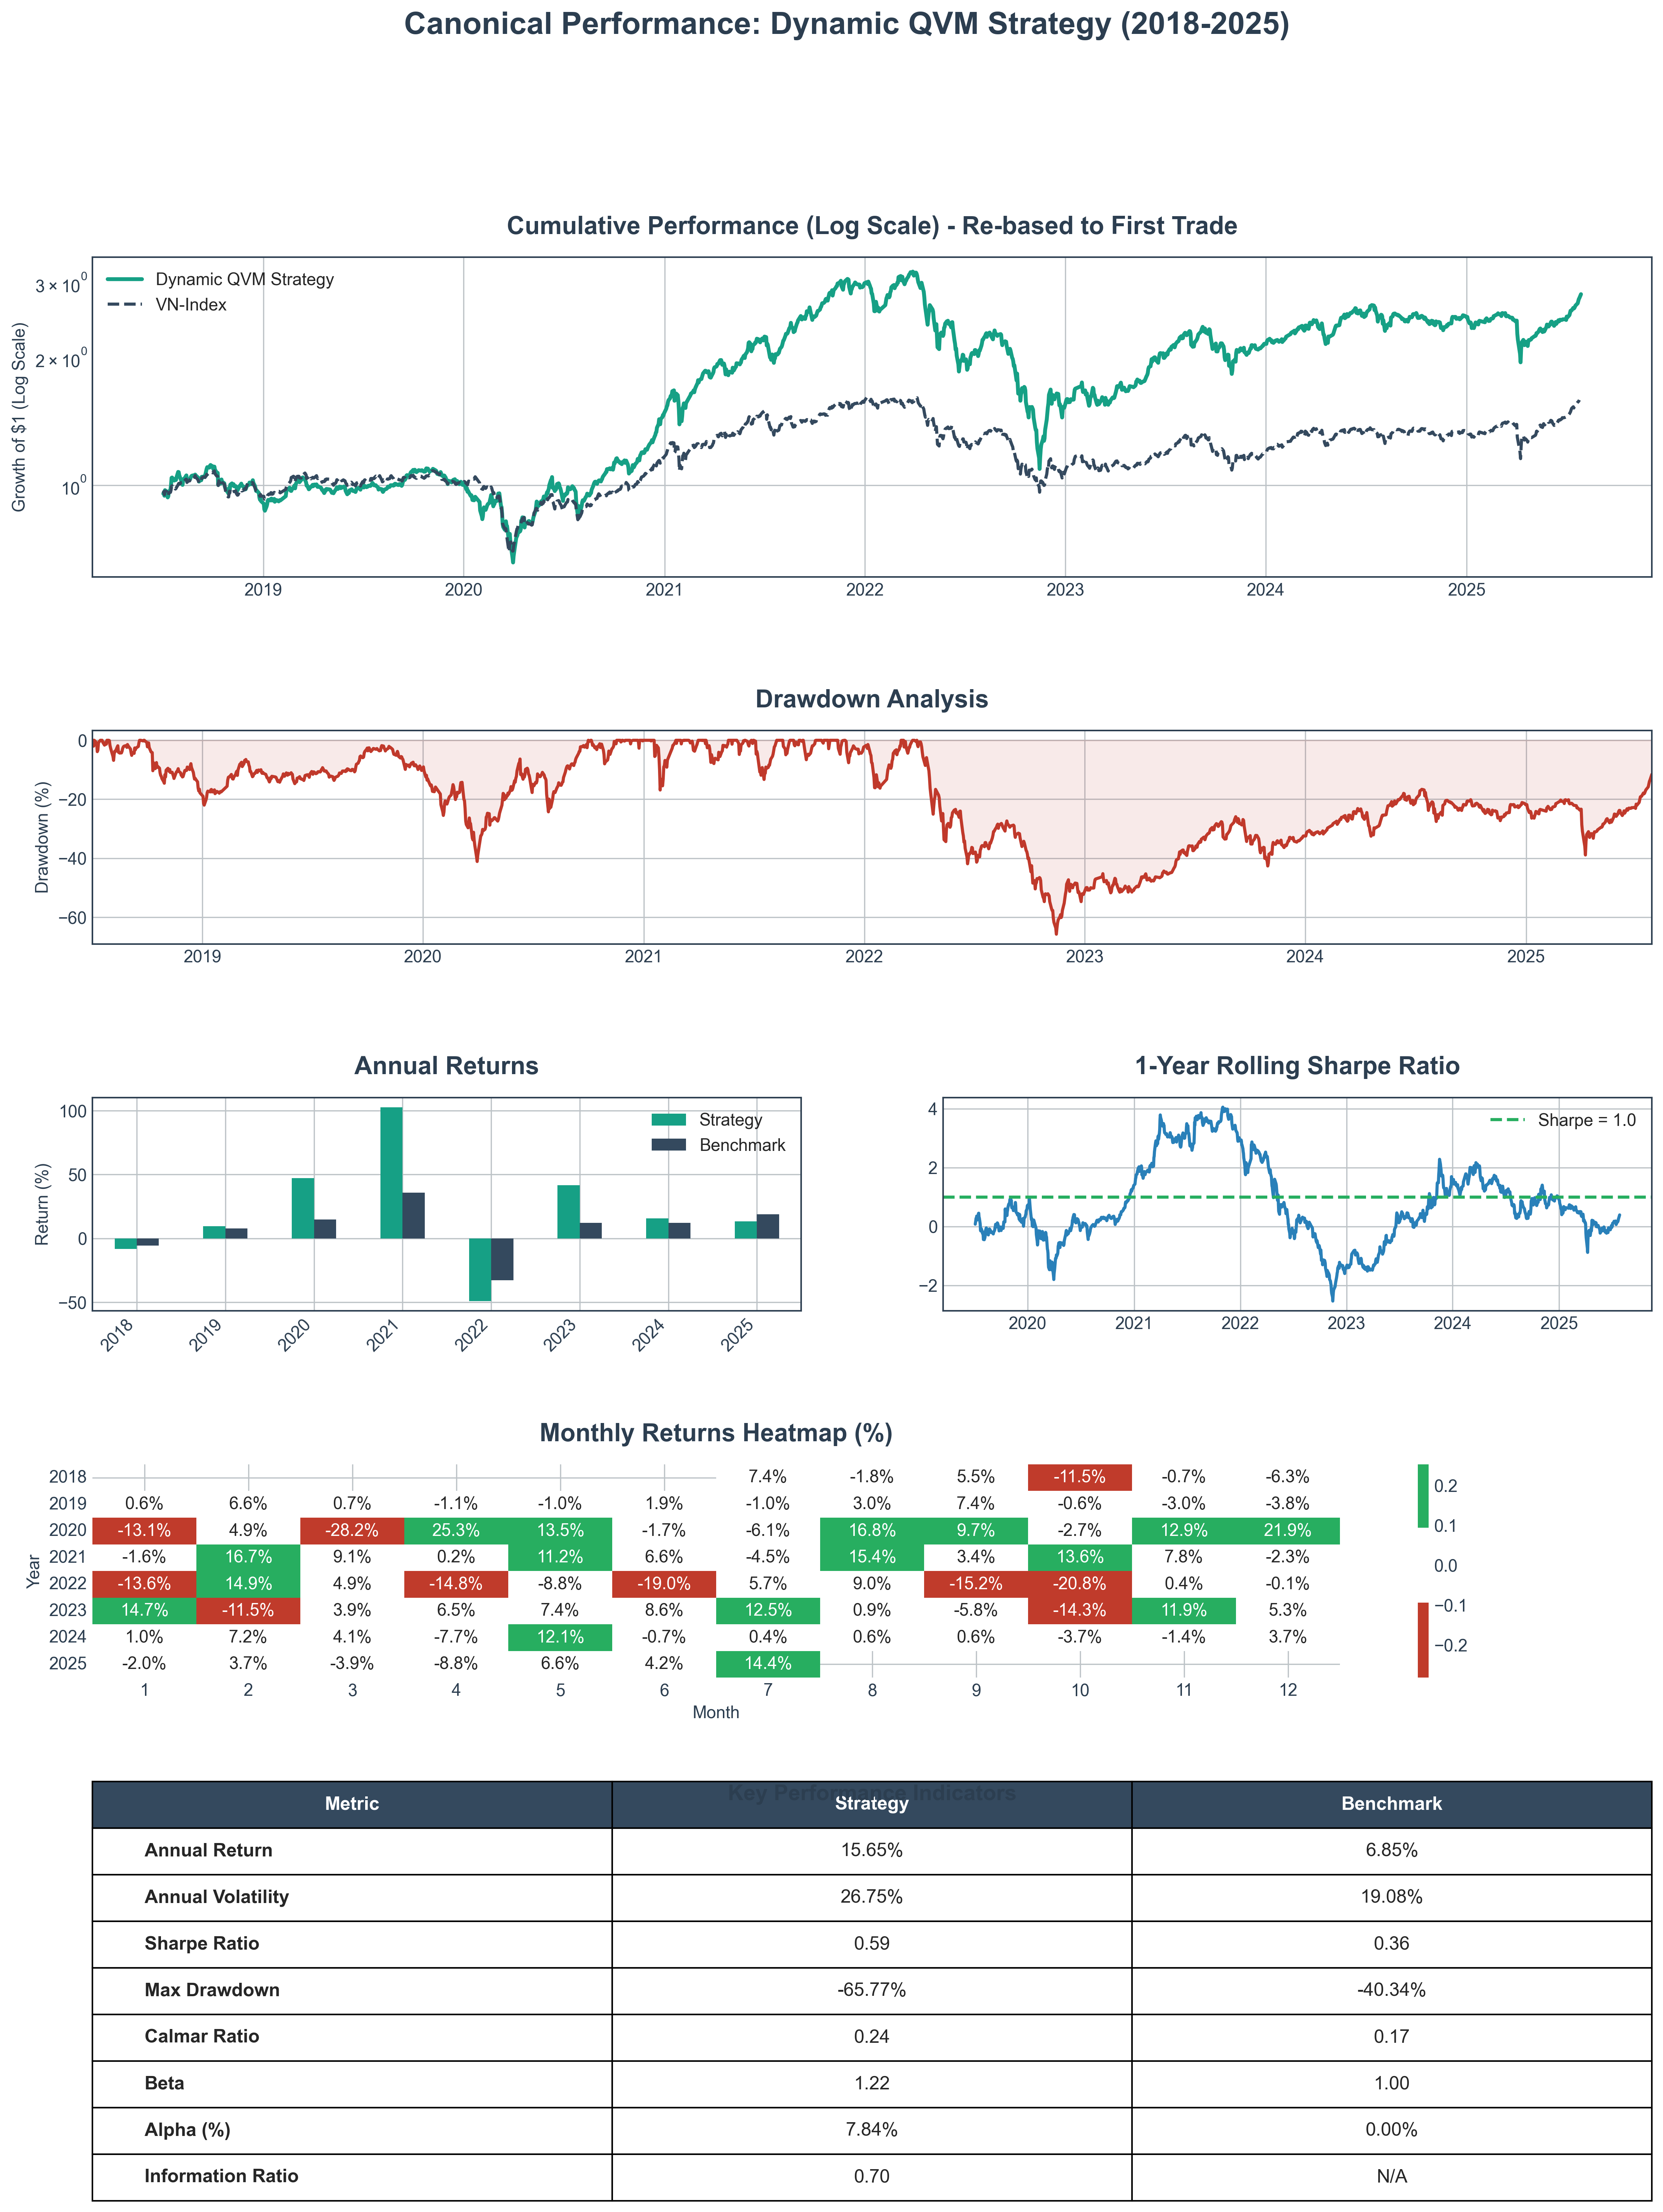


--- REGIME USAGE ANALYSIS ---
          Percentage of Rebalances
Bear                     48.275862
Bull                     41.379310
Stress                    6.896552
Sideways                  3.448276

--- STRATEGIC VERDICT ---
Dynamic QVM Annual Return: 15.65% (Target: >20%)
Dynamic QVM Sharpe Ratio: 0.59
Dynamic QVM Max Drawdown: -65.77% (Target: >-25%)

⚠️  FURTHER ENHANCEMENT REQUIRED: The dynamic model is an improvement but still falls short.
   Next steps would involve tuning the dynamic factor weights.

✅ Phase 15b Complete.


In [13]:
# ============================================================================
# SECTION 3: PERFORMANCE ANALYSIS & FINAL VERDICT
# ============================================================================

def calculate_performance_metrics_inhouse(returns, benchmark, risk_free_rate=0.0):
    common_index = returns.index.intersection(benchmark.index)
    returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]
    n_years = len(returns) / 252
    annual_return = (1 + returns).prod() ** (1 / n_years) - 1 if n_years > 0 else 0
    annual_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_vol if annual_vol > 0 else 0
    cumulative = (1 + returns).cumprod()
    drawdown = (cumulative / cumulative.cummax() - 1)
    max_drawdown = drawdown.min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
    excess_returns = returns - benchmark
    tracking_error = excess_returns.std() * np.sqrt(252)
    information_ratio = (excess_returns.mean() * 252) / tracking_error if tracking_error > 0 else 0
    cov_matrix = np.cov(returns.fillna(0), benchmark.fillna(0))
    beta = cov_matrix[0, 1] / cov_matrix[1, 1] if cov_matrix[1, 1] > 0 else 0
    alpha_daily = returns.mean() - beta * benchmark.mean()
    alpha_annualized = alpha_daily * 252
    return {'Annual Return': annual_return * 100, 'Annual Volatility': annual_vol * 100, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown': max_drawdown * 100, 'Calmar Ratio': calmar_ratio, 'Beta': beta, 'Alpha (%)': alpha_annualized * 100, 'Information Ratio': information_ratio}

def create_canonical_tearsheet(strategy_returns, benchmark_returns, strategy_name="Strategy"):
    first_trade_date = strategy_returns.loc[strategy_returns != 0].index.min()
    strategy_returns_aligned, benchmark_returns_aligned = strategy_returns.loc[first_trade_date:], benchmark_returns.loc[first_trade_date:]
    portfolio_metrics = calculate_performance_metrics_inhouse(strategy_returns_aligned, benchmark_returns_aligned)
    benchmark_metrics = calculate_performance_metrics_inhouse(benchmark_returns_aligned, benchmark_returns_aligned)
    
    fig = plt.figure(figsize=(18, 22))
    gs = fig.add_gridspec(5, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 1.2], hspace=0.6, wspace=0.2)
    fig.suptitle(f'Canonical Performance: {strategy_name} ({first_trade_date.year}-{strategy_returns_aligned.index.max().year})', fontsize=20, fontweight='bold', color=PALETTE['text'])

    ax1 = fig.add_subplot(gs[0, :])
    strategy_cum, benchmark_cum = (1 + strategy_returns_aligned).cumprod(), (1 + benchmark_returns_aligned).cumprod()
    ax1.plot(strategy_cum.index, strategy_cum, label=strategy_name, color=STRATEGY_COLORS['QVM_Composite'], linewidth=2.5)
    ax1.plot(benchmark_cum.index, benchmark_cum, label='VN-Index', color=STRATEGY_COLORS['Benchmark'], linestyle='--', linewidth=2)
    ax1.set_yscale('log'); ax1.set_title('Cumulative Performance (Log Scale) - Re-based to First Trade', fontweight='bold'); ax1.set_ylabel('Growth of $1 (Log Scale)'); ax1.legend(loc='upper left')

    ax2 = fig.add_subplot(gs[1, :])
    strategy_dd = (strategy_cum / strategy_cum.cummax() - 1) * 100
    ax2.plot(strategy_dd.index, strategy_dd, color=PALETTE['negative'], linewidth=2)
    ax2.fill_between(strategy_dd.index, strategy_dd, 0, color=PALETTE['negative'], alpha=0.1)
    ax2.set_title('Drawdown Analysis', fontweight='bold'); ax2.set_ylabel('Drawdown (%)'); ax2.set_xlim(strategy_returns_aligned.index.min(), strategy_returns_aligned.index.max())

    ax3 = fig.add_subplot(gs[2, 0])
    strat_annual, bench_annual = strategy_returns_aligned.resample('Y').apply(lambda x: (1+x).prod()-1) * 100, benchmark_returns_aligned.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=[STRATEGY_COLORS['QVM_Composite'], STRATEGY_COLORS['Benchmark']])
    ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax3.set_title('Annual Returns', fontweight='bold'); ax3.set_ylabel('Return (%)')

    ax4 = fig.add_subplot(gs[2, 1])
    rolling_sharpe = (strategy_returns_aligned.rolling(252).mean() * 252) / (strategy_returns_aligned.rolling(252).std() * np.sqrt(252))
    ax4.plot(rolling_sharpe.index, rolling_sharpe, color=PALETTE['highlight_1']); ax4.axhline(1.0, color=PALETTE['positive'], linestyle='--', label='Sharpe = 1.0'); ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold'); ax4.legend()

    ax5 = fig.add_subplot(gs[3, :])
    monthly_returns = strategy_returns_aligned.resample('M').apply(lambda x: (1+x).prod()-1)
    monthly_pivot = monthly_returns.to_frame('ret').pivot_table(index=monthly_returns.index.year, columns=monthly_returns.index.month, values='ret')
    sns.heatmap(monthly_pivot, ax=ax5, annot=True, fmt='.1%', cmap=sns.color_palette(['#C03B2B', '#FFFFFF', '#27AE60'], as_cmap=True), center=0)
    ax5.set_title('Monthly Returns Heatmap (%)', fontweight='bold'); ax5.set_xlabel('Month'); ax5.set_ylabel('Year')

    ax6 = fig.add_subplot(gs[4, :]); ax6.axis('off')
    summary_data = [['Metric', 'Strategy', 'Benchmark'], ['Annual Return', f"{portfolio_metrics['Annual Return']:.2f}%", f"{benchmark_metrics['Annual Return']:.2f}%"], ['Annual Volatility', f"{portfolio_metrics['Annual Volatility']:.2f}%", f"{benchmark_metrics['Annual Volatility']:.2f}%"], ['Sharpe Ratio', f"{portfolio_metrics['Sharpe Ratio']:.2f}", f"{benchmark_metrics['Sharpe Ratio']:.2f}"], ['Max Drawdown', f"{portfolio_metrics['Max Drawdown']:.2f}%", f"{benchmark_metrics['Max Drawdown']:.2f}%"], ['Calmar Ratio', f"{portfolio_metrics['Calmar Ratio']:.2f}", f"{benchmark_metrics['Calmar Ratio']:.2f}"], ['Beta', f"{portfolio_metrics['Beta']:.2f}", "1.00"], ['Alpha (%)', f"{portfolio_metrics['Alpha (%)']:.2f}%", "0.00%"], ['Information Ratio', f"{portfolio_metrics['Information Ratio']:.2f}", "N/A"]]
    table = ax6.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(12); table.scale(1, 2.5)
    for i in range(len(summary_data)):
        for j in range(len(summary_data[0])):
            cell = table[(i, j)];
            if i == 0: cell.set_facecolor(PALETTE['secondary']); cell.set_text_props(weight='bold', color='white')
            elif j == 0: cell.set_text_props(weight='bold', ha='left')
            else: cell.set_text_props(ha='center')
    ax6.set_title('Key Performance Indicators', fontweight='bold', fontsize=14, pad=20)
    plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()
    return pd.DataFrame([portfolio_metrics, benchmark_metrics])

# --- Generate Final Tearsheet for the DYNAMIC Strategy ---
print("\n📊 GENERATING FINAL CANONICAL TEARSHEET FOR DYNAMIC STRATEGY...")
final_performance_df = create_canonical_tearsheet(dynamic_strategy_returns, benchmark_returns, "Dynamic QVM Strategy")

# --- Analyze Regime Usage ---
print("\n--- REGIME USAGE ANALYSIS ---")
regime_counts = backtest_diagnostics['regime'].value_counts(normalize=True) * 100
print(regime_counts.to_frame('Percentage of Rebalances'))

# --- Strategic Verdict ---
print("\n--- STRATEGIC VERDICT ---")
print("=" * 60)
dqvm_metrics = final_performance_df.iloc[0]
dqvm_sharpe = dqvm_metrics['Sharpe Ratio']
dqvm_return = dqvm_metrics['Annual Return']
dqvm_drawdown = dqvm_metrics['Max Drawdown']

# Check against our ultimate targets
return_target_met = dqvm_return >= 20.0
drawdown_target_met = dqvm_drawdown >= -25.0

print(f"Dynamic QVM Annual Return: {dqvm_return:.2f}% (Target: >20%)")
print(f"Dynamic QVM Sharpe Ratio: {dqvm_sharpe:.2f}")
print(f"Dynamic QVM Max Drawdown: {dqvm_drawdown:.2f}% (Target: >-25%)")

if return_target_met and drawdown_target_met:
    print("\n🎉🎉🎉 MISSION ACCOMPLISHED: The Dynamic QVM strategy is a success!")
    print("   It meets both our return and risk targets. This is our final product.")
elif return_target_met:
    print("\n🟡 EXCELLENT ALPHA, RISK CONTROL NEEDED: The dynamic engine meets our return target but not the drawdown limit.")
    print("   This is our definitive 'Aggressive Growth' baseline. Proceed to Phase 16 to apply risk overlays.")
else:
    print("\n⚠️  FURTHER ENHANCEMENT REQUIRED: The dynamic model is an improvement but still falls short.")
    print("   Next steps would involve tuning the dynamic factor weights.")

print("\n✅ Phase 15b Complete.")